In [1]:
import numpy as np
import numpy as np
from random import randrange

def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        
        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        if verbose:
            print(ix, grad[ix])
        it.iternext() # step to next dimension

    return grad


def eval_numerical_gradient_array(f, x, df, h=1e-5):
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index
    
        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad

def rel_error(x, y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# (re-)load layers
%run homework_modules.ipynb

In [3]:
x = np.random.randn(2, 3)
dout = np.random.randn(2, 3)

dx_num = eval_numerical_gradient_array(SoftMax().updateOutput, x, dout)
dx = SoftMax().updateGradInput(x, dout)

print('Testing SoftMax(errors should be < 1e-6):')
print('\t dx error: ', rel_error(dx_num, dx))

Testing SoftMax(errors should be < 1e-6):
	 dx error:  2.4246892102893526e-11


In [4]:
# x = np.random.randn(2, 3)
# dout = np.random.randn(2, 3)

dx_num = eval_numerical_gradient_array(LogSoftMax().updateOutput, x, dout)
dx = LogSoftMax().updateGradInput(x, dout)

print('Testing LogSoftMax(errors should be < 1e-6):')
print('\t dx error: ', rel_error(dx_num, dx))

Testing LogSoftMax(errors should be < 1e-6):
	 dx error:  3.887514293997239e-11


In [5]:
x = SoftMax().softmax(np.random.randn(10, 6)+5)
target = np.vstack((np.eye(6, 6),np.eye(4, 6)))

dx_num = eval_numerical_gradient(lambda x: ClassNLLCriterionUnstable().updateOutput(x, target), x, verbose=False)
dx = ClassNLLCriterionUnstable().updateGradInput(x, target)

print('Testing ClassNLLCriterionUnstable (errors should be < 1e-6):')
print('\t dx error: ', rel_error(dx_num, dx))

Testing ClassNLLCriterionUnstable (errors should be < 1e-6):
	 dx error:  7.70983914330389e-09


In [6]:
target = np.array([[1,0],[1,0],[0,1],[0,1]])
x = np.array([[.9, .1], [.8, .2], [.3, .7], [.01, .99]])

ClassNLLCriterionUnstable().updateOutput(SoftMax().softmax(x), target)

0.41007095701768714

In [8]:
x = np.random.randn(10, 6)+5
x = LogSoftMax().updateOutput(x)
target = np.vstack((np.eye(6, 6),np.eye(4, 6)))

dx_num = eval_numerical_gradient(lambda x: ClassNLLCriterion().updateOutput(x, target), x, verbose=False)
dx = ClassNLLCriterion().updateGradInput(x, target)

print('Testing ClassNLLCriterion (errors should be < 1e-6):')
print('\t dx error: ', rel_error(dx_num, dx))

Testing ClassNLLCriterion (errors should be < 1e-6):
	 dx error:  6.988888633996435e-11


In [9]:
target = np.array([[1,0],[1,0],[0,1],[0,1]])
x = np.array([[.9, .1], [.8, .2], [.3, .7], [.01, .99]])

ClassNLLCriterion().updateOutput(LogSoftMax().updateOutput(x), target)

0.41007095701768714

In [10]:
x = (np.random.randn(2, 3) - 0.5) * 2
dout = np.random.randn(2, 3)

dx_num = eval_numerical_gradient_array(LeakyReLU().updateOutput, x, dout)
dx = LeakyReLU().updateGradInput(x, dout)

print('Testing LeakyReLU(errors should be < 1e-6):')
print('\t dx error: ', rel_error(dx_num, dx))

Testing LeakyReLU(errors should be < 1e-6):
	 dx error:  3.1881466580795145e-11


In [11]:
x = (np.random.randn(2, 3) - 0.5) * 2
dout = np.random.randn(2, 3)

dx_num = eval_numerical_gradient_array(ELU().updateOutput, x, dout)
dx = ELU().updateGradInput(x, dout)

print('Testing ELU(errors should be < 1e-6):')
print('\t dx error: ', rel_error(dx_num, dx))

Testing ELU(errors should be < 1e-6):
	 dx error:  9.841086234027998e-11


# Homework 02: Basic Artificial Neural Networks

This homework is heavily based on materials from [Practical DL](https://github.com/yandexdataschool/Practical_DL/) course offered by HSE, YSDA and Skoltech.

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design of was heavily inspired by [Torch](http://torch.ch) which is the most convenient neural network environment when the work involves defining new layers. 

This homework requires answering **multiple** questions in [google form](https://goo.gl/forms/4pEVo1aTtgqNd6EI2). Make sure you are entering mail address that you used for registration for DMIA DL. In this notebook you will find clear instructions on what to send and how.

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run homework_modules.ipynb

Optimizer is implemented for you. 

In [3]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x, dx):
        for cur_x, cur_dx in zip(cur_layer_x, cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(
                cur_dx
            ))
            
            np.add(config['momentum'] * cur_old_grad,
                   config['learning_rate'] * cur_dx,
                   out=cur_old_grad)
            cur_x -= cur_old_grad
            i += 1     

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

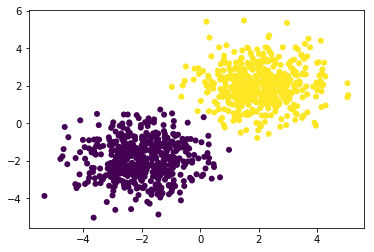

In [4]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

**Logistic regression** is already implented for you.

In [5]:
%run homework_modules.ipynb

In [10]:
net = Sequential()
net.add(Linear(2, 2))
net.add(SoftMax())

criterion = ClassNLLCriterionUnstable()
print(net)

Linear 2 -> 2
SoftMax



Start with batch_size = 1000 to make sure every step lowers the loss.

In [11]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 1000


In [14]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        batch_idx = indices[start:end]
        yield X[batch_idx], Y[batch_idx]
        

### Train

Basic training loop. Examine it.

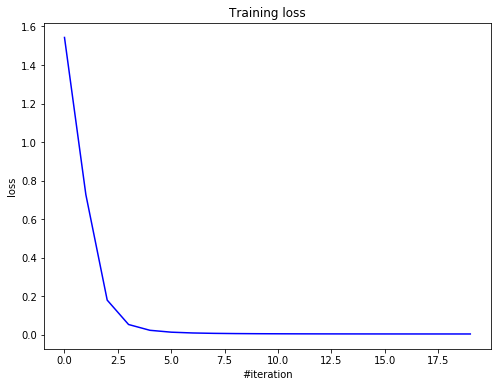

Current loss: 0.003151


In [13]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    print('Current loss: %f'%loss) 

Try **something deeper** in the cell below, for example fully-connected network consisting of Linear -> ReLU -> Linear -> LogSoftMax.

In [14]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 25
batch_size = 1000

In [15]:
net = Sequential()
#######
# Add modules here
net.add(Linear(2, 2))
net.add(ReLU())
net.add(Linear(2, 2))
net.add(LogSoftMax())
criterion = ClassNLLCriterion()
#######
print(net)

Linear 2 -> 2
ReLU
Linear 2 -> 2
LogSoftMax



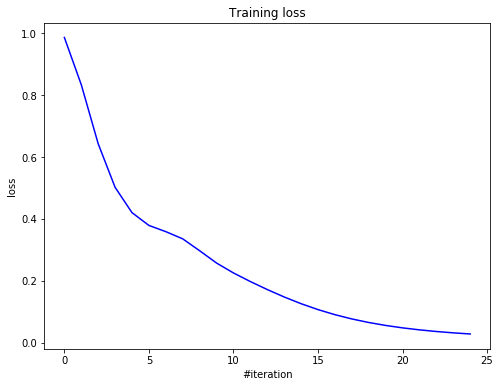

Current loss: 0.028671


In [16]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    print('Current loss: %f'%loss) 

#### Task 1: Loss stability

In the cell below print the integer which answers the question: "during which epoch training loss becomes more or less stable around minimum?", for example: 3. Write your answer in the task 1 of the google form for this homework.

# Your answer goes here. ################################################
15

# Digit classification 

We are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. Lets start with [cool visualization](http://scs.ryerson.ca/~aharley/vis/). The most beautiful demo is the second one, if you are not familiar with convolutions you can return to it in several lectures. 

In [4]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
import os
from sklearn.datasets import fetch_openml

# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = mnist = fetch_openml('mnist_784')
    X, y = mnist.data / 255.0, mnist.target
    np.savez('mnist.npz', X=X, y=y)

In [6]:
X.shape, y.shape

((70000, 784), (70000,))

In [7]:
from collections import defaultdict

label_to_idx = defaultdict(int)

for label in set(y):
    label_to_idx[label] = int(label)
    
print(label_to_idx)

defaultdict(<class 'int'>, {'1': 1, '6': 6, '0': 0, '2': 2, '9': 9, '5': 5, '7': 7, '4': 4, '3': 3, '8': 8})


One-hot encode the labels first.

In [8]:
from tqdm import tqdm

# Your code goes here. ################################################
Y = np.zeros((y.shape[0], 10))
for i in tqdm(range(y.shape[0])):
    idx = label_to_idx[y[i]]
    Y[i, idx] = 1

100%|██████████| 70000/70000 [00:00<00:00, 907911.35it/s]


In [9]:
Y[:10,:]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- Hint: logloss for MNIST should be around 0.5. 

In [23]:
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

### ReLU

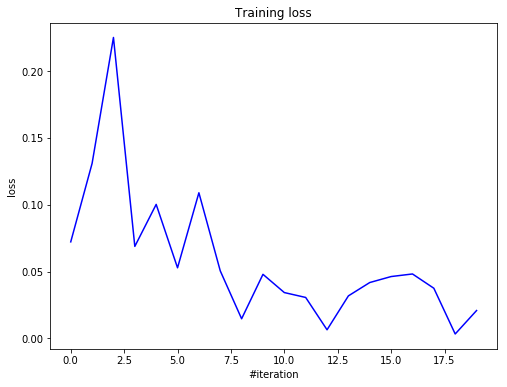

100%|██████████| 20/20 [00:54<00:00,  2.68s/it]

Current loss: 0.020821
Time: 54.35902690887451
ReLU logloss: [0.046250548758528576, 0.04818180601808964, 0.03749935672483531, 0.0032821322540208977, 0.02082143940057784]


In [24]:
criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(784, 50))
net.add(ReLU())
net.add(Linear(50, 10))
net.add(LogSoftMax())

loss_relu = []

t = time()
for i in tqdm(range(n_epoch)):
    for x_batch, y_batch in get_batches((X,Y) , batch_size):
        net.zeroGradParameters()
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)
    loss_relu.append(loss)
    
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_relu, 'b')
    plt.show()
    print('Current loss: %f'%loss)
    
print('Time: {}'.format(time() - t))
print('ReLU logloss: {}'.format(loss_relu[-5:]))

### ELU

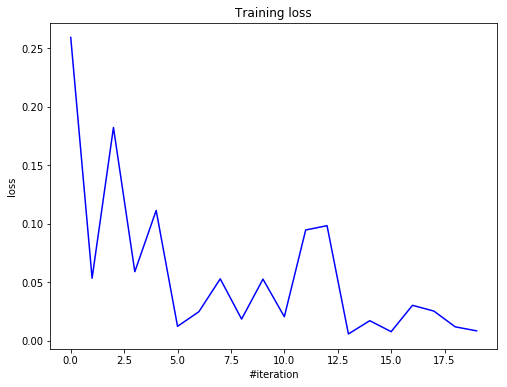

100%|██████████| 20/20 [00:53<00:00,  2.83s/it]

Current loss: 0.008491
Time: 53.69074201583862
ELU logloss: [0.0077661567169942155, 0.03027185080738037, 0.02537802323812638, 0.011905656068066987, 0.00849054988138019]


In [25]:
criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(784, 50))
net.add(ELU())
net.add(Linear(50, 10))
net.add(LogSoftMax())

loss_elu = []
t = time()

for i in tqdm(range(n_epoch)):
    for x_batch, y_batch in get_batches( (X,Y) , batch_size):
        net.zeroGradParameters()        
        predictions = net.forward(x_batch)        
        loss = criterion.forward(predictions, y_batch)        
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
    loss_elu.append(loss)
    
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_elu, 'b')
    plt.show()
    print('Current loss: %f'%loss)
        
print('Time: {}'.format(time() - t))
print('ELU logloss: {}'.format(loss_elu[-5:])) 

### LeakyReLU

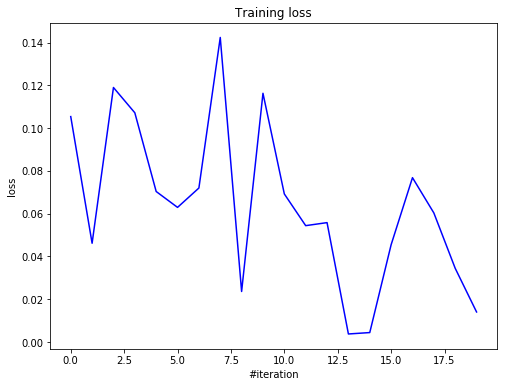

100%|██████████| 20/20 [00:51<00:00,  2.55s/it]

Current loss: 0.014025
Time: 51.74971604347229
ELU logloss: [0.045465216065234626, 0.0768161458148531, 0.060328757540484765, 0.03444259032367677, 0.014025472883615919]


In [26]:
criterion = ClassNLLCriterion()

net = Sequential()
net.add(Linear(784, 50))
net.add(LeakyReLU(0.02))
net.add(Linear(50, 10))
net.add(LogSoftMax())

loss_leakyRelu = []
t = time()

for i in tqdm(range(n_epoch)):
    for x_batch, y_batch in get_batches( (X,Y) , batch_size):
        net.zeroGradParameters()        
        predictions = net.forward(x_batch)        
        loss = criterion.forward(predictions, y_batch)        
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
    loss_leakyRelu.append(loss)
    
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_leakyRelu, 'b')
    plt.show()
    print('Current loss: %f'%loss)
        
print('Time: {}'.format(time() - t))
print('ELU logloss: {}'.format(loss_leakyRelu[-5:])) 

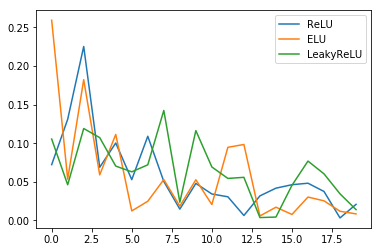

In [27]:
plt.plot(loss_relu)
plt.plot(loss_elu)
plt.plot(loss_leakyRelu)
plt.legend(('ReLU', 'ELU', 'LeakyReLU'))
plt.show()

#### Task 2: ReLU, ELU, LeakyReLu

Print here all the activation functions you checked in the order of increasing performance, for example: elu, leaky_relu, relu (mind the format of the answer). Write your answer in the **task 2** of the google form for this homework.

# Your answer goes here. ################################################
relu, leaky_relu, elu

**Finally**, use all your knowledge to build a super cool model on this dataset, do not forget to split dataset into train and validation.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)

In [11]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(46900, 784) (46900, 10)
(23100, 784) (23100, 10)


Define your network in the cell below.

In [29]:
criterion = ClassNLLCriterion()

net = Sequential()
####### 
# Add modules here
net = Sequential()
net.add(Linear(784, 196))
net.add(ELU())
net.add(Linear(196, 10))
net.add(LogSoftMax())
#######

optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

n_epoch = 20
batch_size = 128

loss_history_train, loss_history_val = [], []

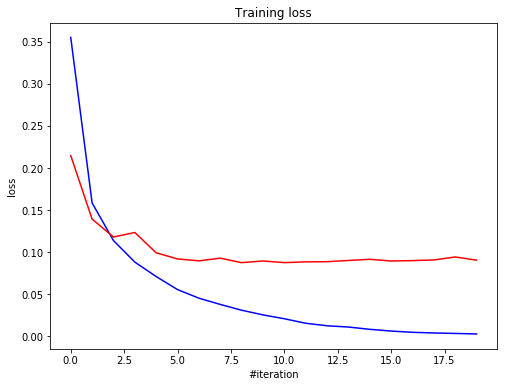

Current loss train: 0.002603
Current loss test:  0.090407
train loss: 0.3552, val loss: 0.2147, train acc: 0.8979, val acc: 0.9340, epoch: 19
train loss: 0.1584, val loss: 0.1392, train acc: 0.9526, val acc: 0.9578, epoch: 19
train loss: 0.1137, val loss: 0.1179, train acc: 0.9658, val acc: 0.9636, epoch: 19
train loss: 0.0881, val loss: 0.1233, train acc: 0.9727, val acc: 0.9620, epoch: 19
train loss: 0.0709, val loss: 0.0991, train acc: 0.9779, val acc: 0.9710, epoch: 19
train loss: 0.0554, val loss: 0.0919, train acc: 0.9823, val acc: 0.9714, epoch: 19
train loss: 0.0452, val loss: 0.0895, train acc: 0.9858, val acc: 0.9740, epoch: 19
train loss: 0.0377, val loss: 0.0928, train acc: 0.9883, val acc: 0.9723, epoch: 19
train loss: 0.0308, val loss: 0.0874, train acc: 0.9902, val acc: 0.9746, epoch: 19
train loss: 0.0253, val loss: 0.0894, train acc: 0.9925, val acc: 0.9749, epoch: 19
train loss: 0.0207, val loss: 0.0875, train acc: 0.9936, val acc: 0.9764, epoch: 19
train loss: 0.0153

In [30]:
loss_train = []
loss_val = []
acc_train = []
acc_val = []

for i in range(n_epoch):
    train_loss = 0
    train_acc = 0
    train_batches = 0
    for x_batch, y_batch in get_batches((X_train,y_train) , batch_size):
        
        net.zeroGradParameters()  
        predictions = net.forward(x_batch)
        train_loss += criterion.forward(predictions, y_batch)
        y_pred = [np.argmax(pred) for pred in predictions]
        y_batch_test = [np.argmax(batch_i) for batch_i in y_batch]
        train_acc += accuracy_score(y_pred, y_batch_test)
        train_batches += 1
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
    val_loss = 0
    val_acc = 0
    val_batches = 0
    for x_batch, y_batch in get_batches( (X_test, y_test) , batch_size):
        predictions = net.forward(x_batch)
        val_loss += criterion.forward(predictions, y_batch)
        y_pred = [np.argmax(pred) for pred in predictions]
        y_batch_test = [np.argmax(batch_i) for batch_i in y_batch]
        val_acc += accuracy_score(y_pred, y_batch_test)
        val_batches += 1
    
    loss_train.append(train_loss / train_batches)
    loss_val.append(val_loss / val_batches)
    acc_train.append(train_acc / train_batches)
    acc_val.append(val_acc / val_batches)
    
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_train, 'b')
    plt.plot(loss_val, 'r')
    plt.show()
    print('Current loss train: %f' % loss_train[-1])
    print('Current loss test:  %f' % loss_val[-1])
    
for train_loss, val_loss, train_acc, val_acc in zip(loss_train, loss_val, acc_train, acc_val):
    print("train loss: {:.4f}, val loss: {:.4f}, train acc: {:.4f}, val acc: {:.4f}, epoch: {}".format(
        train_loss, val_loss, train_acc, val_acc, i))

Current loss train: 0.002516
Current loss test:  0.093991

#### Task 3: Validation accuracy & Task 4: Validation loss

Print here your **validation accuracy** (ex: 0.75) and **validation loss** (ex: 0.1), both rounded up up to 2-nd digit after decimal point. Write your answers in the **tasks 3 (validation accuracy) and 4 (validation loss)** of the google form for this homework.

# Your answer goes here. ################################################
0.97 1.49